# Experiment Four: Sentiment and length and depth
Research Question: How does classification accuracy vary across sentiment classes with increasing node depth and phrase length in n-ary Tree-LSTM models?

Objective:
To examine how classification accuracy differs across sentiment classes as node depth and phrase length increase in n-ary Tree-LSTM models, identifying patterns and potential challenges at varying hierarchical levels.


## Preparing the data

Let's first download the data set and take a look.

In [ ]:
import re
import random
import time
import math
import numpy as np
from collections import defaultdict
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('default')

In [ ]:
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2024-12-12 10:48:21--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2024-12-12 10:48:22--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip’

trainDevTestTrees_P 100%[===================>] 771.03K   272KB/s    in 2.8s    

2024-12-12 10:48:25 (272 KB/s) - ‘trainDevTestTrees_PTB.zip’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
   creating: trees/
  inflating: trees/dev.txt           
  inflating: trees/test.txt          
  inflating: trees/train.txt         


In [ ]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [ ]:
s = next(filereader("trees/train.txt"))
print(s)

(3 (2 (2 The) (2 Rock)) (4 (3 (2 is) (4 (2 destined) (2 (2 (2 (2 (2 to) (2 (2 be) (2 (2 the) (2 (2 21st) (2 (2 (2 Century) (2 's)) (2 (3 new) (2 (2 ``) (2 Conan)))))))) (2 '')) (2 and)) (3 (2 that) (3 (2 he) (3 (2 's) (3 (2 going) (3 (2 to) (4 (3 (2 make) (3 (3 (2 a) (3 splash)) (2 (2 even) (3 greater)))) (2 (2 than) (2 (2 (2 (2 (1 (2 Arnold) (2 Schwarzenegger)) (2 ,)) (2 (2 Jean-Claud) (2 (2 Van) (2 Damme)))) (2 or)) (2 (2 Steven) (2 Segal))))))))))))) (2 .)))


In [ ]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

                                                                                               3                                                                                                                                         
      _________________________________________________________________________________________|____                                                                                                                                      
     |                                                                                              4                                                                                                                                    
     |                      ________________________________________________________________________|__________________________________________________________________________________________________________________________________   
     |                     3                                  

<ipython-input-5-6ab7e95feba4>:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [ ]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.']
36


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [ ]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [ ]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


In [ ]:
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
    print(f"First sentence in {path}:")
    print(next(filereader(path)))


First sentence in trees/train.txt:
(3 (2 (2 The) (2 Rock)) (4 (3 (2 is) (4 (2 destined) (2 (2 (2 (2 (2 to) (2 (2 be) (2 (2 the) (2 (2 21st) (2 (2 (2 Century) (2 's)) (2 (3 new) (2 (2 ``) (2 Conan)))))))) (2 '')) (2 and)) (3 (2 that) (3 (2 he) (3 (2 's) (3 (2 going) (3 (2 to) (4 (3 (2 make) (3 (3 (2 a) (3 splash)) (2 (2 even) (3 greater)))) (2 (2 than) (2 (2 (2 (2 (1 (2 Arnold) (2 Schwarzenegger)) (2 ,)) (2 (2 Jean-Claud) (2 (2 Van) (2 Damme)))) (2 or)) (2 (2 Steven) (2 Segal))))))))))))) (2 .)))
First sentence in trees/dev.txt:
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
First sentence in trees/test.txt:
(2 (3 (3 Effective) (2 but)) (1 (1 too-tepid) (2 biopic)))


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [ ]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


Let's check out an `Example` object.

In [ ]:
example = dev_data[0]
print("First example:", example)
print("First example tokens:", example.tokens)
print("First example label:",  example.label)

First example: Example(tokens=['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], tree=Tree('3', [Tree('2', ['It']), Tree('4', [Tree('4', [Tree('2', ["'s"]), Tree('4', [Tree('3', [Tree('2', ['a']), Tree('4', [Tree('3', ['lovely']), Tree('2', ['film'])])]), Tree('3', [Tree('2', ['with']), Tree('4', [Tree('3', [Tree('3', ['lovely']), Tree('2', ['performances'])]), Tree('2', [Tree('2', ['by']), Tree('2', [Tree('2', [Tree('2', ['Buy']), Tree('2', ['and'])]), Tree('2', ['Accorsi'])])])])])])]), Tree('2', ['.'])])]), label=3, transitions=[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
First example tokens: ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
First example label: 3


In [ ]:
def prepare_example(example, vocab):
    """
    Prepare input and label for a single example, including transitions.
    """
    # Map tokens to IDs
    x = [vocab.w2i.get(t, 0) for t in example.tokens]  # 0 is <unk>
    x = torch.LongTensor([x]).to(device)

    # Extract transitions
    transitions = example.transitions  # Ensure example has `transitions`
    transitions = torch.LongTensor(transitions).to(device)

    # Get label
    y = torch.LongTensor([example.label]).to(device)

    return x, transitions, y


#### Vocabulary
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [ ]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [ ]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [ ]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})

## PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [ ]:
import torch
print("Using torch", torch.__version__) # should say 1.7.0+cu101

Using torch 2.5.1+cu121


In [ ]:
# Let's also import torch.nn, a PyTorch package that
# makes building neural networks more convenient.
from torch import nn

In [ ]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(42)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [ ]:
# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


#print_parameters(bow_model)

#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table.

In [ ]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [ ]:
x, y = prepare_example(dev_data[0], v)
print('x:', x)
print('y:', y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='cuda:0')
y: tensor([3], device='cuda:0')


#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [ ]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later)

  for example in data:

    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass without backpropagation (no_grad)
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)

    # get the prediction
    prediction = logits.argmax(dim=-1)

    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1

  return correct, total, correct / float(total)

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [ ]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

**Optimisation**

As mentioned in the "Intro to PyTorch" notebook, one of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model.

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent).

The package we will use to do this optimisation is [torch.optim](https://pytorch.org/docs/stable/optim.html).

In [ ]:
from torch import optim

In [ ]:
def train_model(model, optimizer, num_iterations=10000,
                print_every=1000, eval_every=1000,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None):
  """Train a model."""
  iter_i = 0
  train_loss = 0.
  print_num = 0
  start = time.time()
  criterion = nn.CrossEntropyLoss() # loss function
  best_eval = 0.
  best_iter = 0

  # store train loss and validation accuracy during training
  # so we can plot them afterwards
  losses = []
  accuracies = []

  if eval_batch_size is None:
    eval_batch_size = batch_size

  while True:  # when we run out of examples, shuffle and continue
    for batch in batch_fn(train_data, batch_size=batch_size):

      # forward pass
      model.train()
      x, targets = prep_fn(batch, model.vocab)
      logits = model(x)

      B = targets.size(0)  # later we will use B examples per update

      # compute cross-entropy loss (our criterion)
      # note that the cross entropy loss function computes the softmax for us
      loss = criterion(logits.view([B, -1]), targets.view(-1))
      train_loss += loss.item()

      # backward pass (tip: check the Introduction to PyTorch notebook)

      # erase previous gradients
      optimizer.zero_grad()

      # compute gradients
      loss.backward()

      # update weights - take a small step in the opposite dir of the gradient
      optimizer.step()


      print_num += 1
      iter_i += 1

      # print info
      if iter_i % print_every == 0:
        print("Iter %r: loss=%.4f, time=%.2fs" %
              (iter_i, train_loss, time.time()-start))
        losses.append(train_loss)
        print_num = 0
        train_loss = 0.

      # evaluate
      if iter_i % eval_every == 0:
        _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                 batch_fn=batch_fn, prep_fn=prep_fn)
        accuracies.append(accuracy)
        print("iter %r: dev acc=%.4f" % (iter_i, accuracy))

        # save best model parameters
        if accuracy > best_eval:
          print("new highscore")
          best_eval = accuracy
          best_iter = iter_i
          path = "{}.pt".format(model.__class__.__name__)
          ckpt = {
              "state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "best_eval": best_eval,
              "best_iter": best_iter
          }
          torch.save(ckpt, path)

      # done training
      if iter_i == num_iterations:
        print("Done training")

        # evaluate on train, dev, and test with best model
        print("Loading best model")
        path = "{}.pt".format(model.__class__.__name__)
        ckpt = torch.load(path)
        model.load_state_dict(ckpt["state_dict"])

        _, _, train_acc = eval_fn(
            model, train_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, dev_acc = eval_fn(
            model, dev_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, test_acc = eval_fn(
            model, test_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)

        print("best model iter {:d}: "
              "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                  best_iter, train_acc, dev_acc, test_acc))

        return losses, accuracies, test_acc

# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**.
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014.

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space.

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove.
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [ ]:
import requests

# URL to the globr file
url = "https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt"

# File name to save the downloaded file
file_name = "glove.filtered.txt"

# Download the file
print("Downloading glove file...")
response = requests.get(url)

# Save the file locally
with open(file_name, "wb") as f:
    f.write(response.content)

print(f"File downloaded and saved as {file_name}")

File downloaded and saved as glove.filtered.txt


In [ ]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# What do you see?
# Print the first few lines of the file
with open("glove.filtered.txt", "r", encoding="utf-8") as f:
    for i in range(5):
        print(f.readline().strip())


, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.3

In [ ]:
# Parse the glove file
glove = {}
with open("glove.filtered.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]  # The first value is the word
        vector = [float(x) for x in values[1:]]  # The rest are the embedding values
        glove[word] = vector

print(f"Loaded {len(glove)} word embeddings!")

# Initialize vocabulary object
v = Vocabulary()

# Add special tokens manually
v.add_token("<unk>")
v.add_token("<pad>")

# Define embedding dimensions and initialize list for vectors
embedding_dim = 300  # Update if using different dimensions
vectors = []

# Add special token embeddings
vectors.append(np.random.uniform(-0.01, 0.01, embedding_dim))  # <unk>
vectors.append(np.zeros(embedding_dim))  # <pad>

# Add pre-trained word embeddings to vocabulary
for word, vector in glove.items():
    if word not in v.w2i:  # If the word is not already in the vocab
        v.add_token(word)
        vectors.append(vector)

# Convert vectors to a NumPy array
vectors = np.stack(vectors, axis=0)

# Print vocabulary size and first few entries
print(f"Vocabulary size: {len(v.w2i)}")
print("First 10 vocabulary entries:")
for i, word in enumerate(v.i2w[:10]):
    print(f"{i}: {word}")


Loaded 20725 word embeddings!
Vocabulary size: 20727
First 10 vocabulary entries:
0: <unk>
1: <pad>
2: ,
3: .
4: the
5: and
6: to
7: of
8: a
9: in


Create a function to set set for reproducbility.

In [ ]:
def set_seed(seed):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Enforce determinism in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Mini-batching



In [ ]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""

  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch

  batch = []

  # yield minibatches
  for example in data:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [ ]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [ ]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [ ]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
  print(ex)

Example(tokens=['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], tree=Tree('3', [Tree('2', [Tree('2', ['The']), Tree('2', ['Rock'])]), Tree('4', [Tree('3', [Tree('2', ['is']), Tree('4', [Tree('2', ['destined']), Tree('2', [Tree('2', [Tree('2', [Tree('2', [Tree('2', ['to']), Tree('2', [Tree('2', ['be']), Tree('2', [Tree('2', ['the']), Tree('2', [Tree('2', ['21st']), Tree('2', [Tree('2', [Tree('2', ['Century']), Tree('2', ["'s"])]), Tree('2', [Tree('3', ['new']), Tree('2', [Tree('2', ['``']), Tree('2', ['Conan'])])])])])])])]), Tree('2', ["''"])]), Tree('2', ['and'])]), Tree('3', [Tree('2', ['that']), Tree('3', [Tree('2', ['he']), Tree('3', [Tree('2', ["'s"]), Tree('3', [Tree('2', ['going']), Tree('3', [Tree('2', ['to']), Tree('4', [Tree('3', [Tree('

In [ ]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[   23,  1414,    11,  8222,     6,    27,     4,  2826,  3764,    21,
            92,  5233,  8558, 15010,     5,    16,    53,    21,   183,     6,
           107,     8,  7409,   148,  1552,    97,  6000, 10464,     2,     0,
          2740, 15451,    33,  4008, 12925,     3,     1,     1,     1],
        [   23, 15300,  6665,  8307,     7,  5233,    23,  1383,     7,     4,
          4884, 15010,  8681,    11,    59,   933,    16,     8,  3045,     7,
           566,    42,    36,  7800,  2886, 20302,  1433,  1977,    21,  4360,
          2274,     7, 15256, 10099,    21, 15561,     3,     1,     1],
        [    0,  5314,  3878,  7735,     8,  9726,     7,  1261,   158,     8,
           219,  1060,  2187,     2,     8,   219,    50,   688, 11605,     6,
             4,   414,   158,    43,     4,   494,  1568,  1214,  6985,     4,
          2243,     2,  5986,     2,  2320,     7,     4,   982,     3]],
       device='cuda:0')
y tensor([3, 4, 3], device='cuda:0')


#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [ ]:
def evaluate(model, data,
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
                  # The model now returns both root_logits and node_predictions
      root_logits, _ = model(x)  # Extract only the root_logits

    predictions = root_logits.argmax(dim=-1).view(-1)

    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

# Tree-LSTM

In the final part of this lab we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [ ]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

                                                                                               3                                                                                                                                         
      _________________________________________________________________________________________|____                                                                                                                                      
     |                                                                                              4                                                                                                                                    
     |                      ________________________________________________________________________|__________________________________________________________________________________________________________________________________   
     |                     3                                  

<ipython-input-43-6ab7e95feba4>:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


In [ ]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-44-0d63b35e49bd>:2: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(ex.tree))


In [ ]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [ ]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation
    # The shape of each of these is [batch_size, hidden_size]

    # Apply activations
    i = torch.sigmoid(i)          # Input gate
    f_l = torch.sigmoid(f_l)      # Left forget gate
    f_r = torch.sigmoid(f_r)      # Right forget gate
    g = torch.tanh(g)             # Candidate memory
    o = torch.sigmoid(o)          # Output gate

    # Compute the new cell state
    c = i * g + f_l * prev_c_l + f_r * prev_c_r

    # Compute the new hidden state
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class




In [ ]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

## Key Modifications:
Logging Intermediate Representations:
The node_logs list stores the hidden states generated after every REDUCE operation. This allows us to keep track of how the representation evolves through each step in the tree.
Returning node_logs:
We modified the return value of the forward function to return both final (the root node representation) and node_logs (the intermediate representations).

In [ ]:
class TreeLSTM(nn.Module):
    """Encodes a sentence using a TreeLSTMCell"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(TreeLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.hidden_proj = nn.Linear(embedding_dim, 150)  # Project to hidden_dim size

        self.reduce = TreeLSTMCell(input_size, hidden_size)

        # Project word to initial c
        self.proj_x = nn.Linear(input_size, hidden_size)
        self.proj_x_gate = nn.Linear(input_size, hidden_size)

        self.buffers_dropout = nn.Dropout(p=0.5)

    def forward(self, x, transitions):
        """
        WARNING: assuming x is reversed!
        :param x: word embeddings [B, T, E]
        :param transitions: [2T-1, B]
        :return: root states
        """
        B = x.size(0)  # batch size
        T = x.size(1)  # time

        # Compute an initial c and h for each word
        buffers_c = self.proj_x(x)
        buffers_h = buffers_c.tanh()
        buffers_h_gate = self.proj_x_gate(x).sigmoid()
        buffers_h = buffers_h_gate * buffers_h

        # Concatenate h and c for each word
        buffers = torch.cat([buffers_h, buffers_c], dim=-1)

        # Turn buffers into a list of stacks (1 stack for each sentence)
        buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
        buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

        # Create B empty stacks
        stacks = [[] for _ in buffers]

        # List to store the hidden states of intermediate nodes
        node_logs = []

        # t_batch holds 1 transition for each sentence
        for t_batch in transitions:
            child_l = []  # Left child for each sentence with reduce action
            child_r = []  # Right child for each sentence with reduce action

            # Iterate over sentences in the batch
            for transition, buffer, stack in zip(t_batch, buffers, stacks):
                if transition == SHIFT:
                    stack.append(buffer.pop())
                    node_logs.append(stack[-1])  # Log the current leaf node

                elif transition == REDUCE:
                    assert len(stack) >= 2, "Stack too small! Should not happen with valid transition sequences"
                    child_r.append(stack.pop())  # Right child is on top
                    child_l.append(stack.pop())

            if child_l:
              # Perform batched reduce operation
              reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
              # Unbatch into individual (h, c) pairs for each node
              #reduced = iter(unbatch(reduced))

              for transition, stack in zip(t_batch, stacks):
                if transition == REDUCE:
                  h = next(reduced)
                  node_logs.append(h)  # Get prediction for each node
                  stack.append(h)

        final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
        final = torch.cat(final, dim=0)  # tensor [B, D]

        # Return root states and all intermediate node logs for later analysis
        return final, node_logs


Just like the LSTM before, we will need an extra class that does the classifications.

In [ ]:
class TreeLSTMClassifier(nn.Module):
    """
    Encodes sentence with a TreeLSTM and projects final hidden state
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab, seed = None):
        super(TreeLSTMClassifier, self).__init__()
        self.seed = seed
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
        self.hidden_proj = nn.Linear(300, hidden_dim)
        self.output_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, output_dim, bias=True)
        )

    def forward(self, x):
        # x is a pair here of words and transitions; we unpack it here.
        # x is batch-major: [B, T], transitions is time major [2T-1, B]
        x, transitions = x
        emb = self.embed(x)

        # Use TreeLSTM to get the root states and all node logs
        root_states, node_logs = self.treelstm(emb, transitions)

        # Make a prediction at the root level using the final hidden state
        root_logits = self.output_layer(root_states)

        # Create a list to store predictions at each intermediate node
        node_predictions = []

        # Make predictions for each intermediate node hidden state
        for node_state in node_logs:
            node_state = self.hidden_proj(node_state)
            # Use the output layer to make a prediction for this node
            node_logits = self.output_layer(node_state)
            node_predictions.append(node_logits)

        # Return root predictions and node predictions
        # root_logits -> final prediction for the entire sentence
        # node_predictions -> predictions for intermediate nodes
        return root_logits, node_predictions


Key Changes:
Calculate Node-Level Losses:

After computing the root-level loss (root_loss), we iterate over the node-level predictions (node_predictions).
Each node’s logits are passed to the cross-entropy loss function (criterion) to compute a loss.
These losses are accumulated in node_losses.
Combine Losses:

The root loss and the total node-level loss are combined to form the total loss (total_loss).
The model uses this total loss to compute gradients and update weights, ensuring that it learns from both root-level and intermediate node-level errors.
Backpropagation:

Total loss is used for backpropagation (total_loss.backward()), ensuring that the model learns from both types of predictions.
Regular Updates:

Printing the loss every print_every steps and evaluating the model every eval_every steps continues as in the original loop.
The best model is saved based on the highest accuracy observed during evaluation.

In [ ]:
def train_model(model, optimizer, num_iterations=10000,
                print_every=1000, eval_every=1000,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None, seed = None):
    """
    Train a model with both root and node-level losses.
    """
    training_data = train_data[:]
    iter_i = 0
    train_loss = 0.0
    print_num = 0
    start = time.time()
    criterion = nn.CrossEntropyLoss()  # Loss function
    best_eval = 0.0
    best_iter = 0

    # Store train loss and validation accuracy during training
    losses = []
    accuracies = []

    if eval_batch_size is None:
        eval_batch_size = batch_size

    while True:  # When we run out of examples, shuffle and continue
        for batch in batch_fn(train_data, batch_size=batch_size):

            # Forward pass
            model.train()
            x, targets = prep_fn(batch, model.vocab)
            root_logits, node_predictions = model(x)

            B = targets.size(0)  # Batch size

            # Compute loss for root-level prediction
            root_loss = criterion(root_logits.view([B, -1]), targets.view(-1))

            # Combine root loss and node-level loss
            total_loss = root_loss

            train_loss += total_loss.item()

            # Backward pass
            optimizer.zero_grad()  # Erase previous gradients
            total_loss.backward()  # Compute gradients
            optimizer.step()  # Update weights

            print_num += 1
            iter_i += 1

            # Print info
            if iter_i % print_every == 0:
                print("Iter %r: loss=%.4f, time=%.2fs" % (iter_i, train_loss, time.time() - start))
                losses.append(train_loss)
                print_num = 0
                train_loss = 0.0

            # Evaluate on dev set
            if iter_i % eval_every == 0:
                _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                         batch_fn=batch_fn, prep_fn=prep_fn)
                accuracies.append(accuracy)
                print("iter %r: dev acc=%.4f" % (iter_i, accuracy))

                # Save best model parameters
                if accuracy > best_eval:
                    print("new highscore")
                    best_eval = accuracy
                    best_iter = iter_i
                    path = "{}_seed_{}.pt".format(model.__class__.__name__, model.seed)
                    ckpt = {
                        "state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "best_eval": best_eval,
                        "best_iter": best_iter
                    }
                    torch.save(ckpt, path)

            # Done training
            if iter_i == num_iterations:
                print("Done training")

                # Evaluate on train and dev set with best model
                print("Loading best model")
                path = "{}_seed_{}.pt".format(model.__class__.__name__, model.seed)
                ckpt = torch.load(path)
                model.load_state_dict(ckpt["state_dict"])

                _, _, train_acc = eval_fn(
                    model, train_data, batch_size=eval_batch_size,
                    batch_fn=batch_fn, prep_fn=prep_fn)
                _, _, dev_acc = eval_fn(
                    model, dev_data, batch_size=eval_batch_size,
                    batch_fn=batch_fn, prep_fn=prep_fn)

                print("best model iter {:d}: "
                      "train acc={:.4f}, dev acc={:.4f}".format(
                          best_iter, train_acc, dev_acc))

                return losses, accuracies, best_eval, path


## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [ ]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major

  return (x, transitions), y

In [ ]:
def prepare_single_example(example, vocab):
    x = [vocab.w2i.get(t, 0) for t in example.tokens]
    x = torch.LongTensor([x]).to(device)

    # Reshape transition to [num_transitions, 1] for single example
    transitions = torch.LongTensor(example.transitions).unsqueeze(1).to(device)

    y = torch.LongTensor([example.label]).to(device)

    node_targets = [int(node.label()) for node in example.tree.subtrees()]
    node_targets = torch.LongTensor(node_targets).to(device)

    return (x, transitions), y, node_targets  # Return node targets

## Train model

In [ ]:
# Define the random seeds
seeds = [42, 123, 999]
best_eval_accuracy = 0.0
best_model_path = None
all_results = []

for seed in seeds:
    # Set the random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Initialize the model
    tree_lstm_model = TreeLSTMClassifier(
        vocab_size=len(v.w2i),
        embedding_dim=300,
        hidden_dim=150,
        output_dim=len(t2i),
        vocab=v
    ).to(device)

    # Track the seed for logging purposes (optional)
    tree_lstm_model.seed = seed

    # Initialize the optimizer
    optimizer = torch.optim.Adam(tree_lstm_model.parameters(), lr=3e-4)

    # Load pre-trained word embeddings
    with torch.no_grad():
        tree_lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        tree_lstm_model.embed.weight.requires_grad = False

    # Train the model
    losses, accuracies, eval_accuracy, model_path = train_model(
        model=tree_lstm_model,
        optimizer=optimizer,
        num_iterations=1704,
        print_every=250,
        eval_every=250,
        prep_fn=prepare_treelstm_minibatch,
        eval_fn=evaluate,
        batch_fn=get_minibatch,
        batch_size=25,
        eval_batch_size=25
    )

    # Store the result for this seed
    all_results.append((seed, eval_accuracy, model_path))

    # Update the best model if it has the highest validation accuracy
    if eval_accuracy > best_eval_accuracy:
        best_eval_accuracy = eval_accuracy
        best_model_path = model_path

# Load the best model based on validation accuracy
if best_model_path:
    print(f"Loading the best model from path: {best_model_path}")
    best_ckpt = torch.load(best_model_path)
    best_model = TreeLSTMClassifier(
        vocab_size=len(v.w2i),
        embedding_dim=300,
        hidden_dim=150,
        output_dim=len(t2i),
        vocab=v
    ).to(device)
    best_model.load_state_dict(best_ckpt["state_dict"])

# Report the mean and standard deviation of the validation accuracies across different seeds
accuracies = [result[1] for result in all_results]
print(f"Validation Accuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies):.4f}, Standard Deviation: {np.std(accuracies):.4f}")


Shuffling training data
Iter 250: loss=374.0947, time=48.41s
iter 250: dev acc=0.3924
new highscore
Shuffling training data
Iter 500: loss=330.3558, time=98.81s
iter 500: dev acc=0.4214
new highscore
Shuffling training data
Iter 750: loss=318.4138, time=150.82s
iter 750: dev acc=0.4242
new highscore
Iter 1000: loss=310.5360, time=205.82s
iter 1000: dev acc=0.4432
new highscore
Shuffling training data
Iter 1250: loss=301.8280, time=260.98s
iter 1250: dev acc=0.4487
new highscore
Shuffling training data
Iter 1500: loss=296.0855, time=311.23s
iter 1500: dev acc=0.4505
new highscore
Done training
Loading best model


<ipython-input-51-11ef100ca909>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 1500: train acc=0.5101, dev acc=0.4505
Shuffling training data
Iter 250: loss=371.0790, time=58.17s
iter 250: dev acc=0.3851
new highscore
Shuffling training data
Iter 500: loss=327.0506, time=112.19s
iter 500: dev acc=0.4196
new highscore
Shuffling training data
Iter 750: loss=318.3664, time=164.21s
iter 750: dev acc=0.4360
new highscore
Iter 1000: loss=307.6221, time=215.74s
iter 1000: dev acc=0.4514
new highscore
Shuffling training data
Iter 1250: loss=302.0647, time=266.74s
iter 1250: dev acc=0.4478
Shuffling training data
Iter 1500: loss=294.2226, time=317.75s
iter 1500: dev acc=0.4469
Done training
Loading best model
best model iter 1000: train acc=0.4759, dev acc=0.4514
Shuffling training data
Iter 250: loss=371.3390, time=47.03s
iter 250: dev acc=0.3896
new highscore
Shuffling training data
Iter 500: loss=328.1257, time=97.53s
iter 500: dev acc=0.4360
new highscore
Shuffling training data
Iter 750: loss=314.3562, time=148.42s
iter 750: dev acc=0.4251
Iter 1000: 

<ipython-input-54-2c15438e46e1>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_ckpt = torch.load(best_model_path)


# **Experiment 4**

## Evaluate errors at nodes

In [ ]:
from nltk import Tree

def evaluate_with_node_logging(model, data, vocab, prep_fn):
    """
    Evaluate the model and log errors at each node where a REDUCE operation occurs,
    using the exact subtree to determine the full phrase or sentence.
    """
    model.eval()
    errors = []
    all_root_correct = 0
    total_samples = 0

    with torch.no_grad():
        for example_idx, example in enumerate(data):
            # Prepare the input for a single example
            x, target, node_targets = prep_fn(example, vocab)
            root_logits, node_logs = model(x)

            # Extract root node text dynamically
            root_text = " ".join(example.tree.leaves()) if hasattr(example, "tree") else "ROOT"

            # Log root prediction
            root_pred = root_logits.argmax(dim=1).item()
            root_gt = target.item()

            if root_pred == root_gt:
                all_root_correct += 1
            else:
                errors.append({
                    "type": "root",
                    "ground_truth": root_gt,
                    "prediction": root_pred,
                    "node_text": root_text,
                    "depth": 1,
                    "example_id": example_idx,
                })

            # Traverse the tree structure and log node predictions
            _, transitions = x
            transitions = transitions.squeeze()  # Remove extra batch dimensions

            # Convert the example into an NLTK Tree
            tree = Tree.fromstring(str(example.tree))

            prediction_idx = 0

            def traverse_and_log(tree, prediction_idx, current_depth, skip_root=True):
                """
                Recursively traverse the tree and log errors, using the full subtree as the source.
                """
                nonlocal errors

                if isinstance(tree, Tree):
                    # Skip logging the root node in the traversal
                    if not skip_root or current_depth > 1:
                        # Extract the full subtree as text
                        node_text = " ".join(tree.flatten())  # Flattened subtree as a full phrase
                        node_word_count = len(node_text.split()) # length of each phrase

                        if prediction_idx < len(node_logs):
                            node_pred = node_logs[prediction_idx].argmax(dim=-1).item()
                            ground_truth = node_targets[prediction_idx].item()

                            # Log mismatch if any
                            if node_pred != ground_truth:
                                errors.append({
                                    "type": "node",
                                    "ground_truth": ground_truth,
                                    "prediction": node_pred,
                                    "node_text": node_text,  # Log the exact text from the subtree
                                    "depth": current_depth,
                                    "node_word_count": node_word_count,
                                    "example_id": example_idx  # Include example ID here
                                })

                            # Increment prediction index after processing the current node
                            prediction_idx += 1

                    # Recur for child nodes and track depth
                    for child in tree:
                        prediction_idx = traverse_and_log(child, prediction_idx, current_depth + 1, skip_root=False)

                return prediction_idx

            # Start the traversal from the root of the tree
            traverse_and_log(tree, prediction_idx, 1)

            total_samples += 1

    # Calculate and print root accuracy
    accuracy = all_root_correct / total_samples
    print(f"Root accuracy: {accuracy * 100:.2f}%")
    print(f"Total samples evaluated: {total_samples}")
    print(f"Total errors logged: {len(errors)}")

    return errors


In [ ]:
errors = evaluate_with_node_logging(
    model=best_model,
    data=test_data,
    vocab=v,
    prep_fn=prepare_single_example
)

Root accuracy: 41.72%
Total samples evaluated: 2210
Total errors logged: 67993


## Error Proportion Rates

## Flatten tree

In [ ]:
def assign_correct_depths(errors, data):
    """
    Assign correct depths to errors based on the original tree structure, excluding root node reassignment.
    """
    def flatten_tree(tree):
        """
        Flattens a tree into a single string of all its leaves.
        """
        if isinstance(tree, Tree):
            return " ".join(tree.leaves())
        return tree

    for error in errors:
        # Skip processing for root nodes, retain the original depth
        if error["type"] == "root":
            continue

        example_id = error["example_id"]
        original_tree = data[example_id].tree  # Assuming each example has a tree attribute
        node_text = error["node_text"]

        def find_depth(tree, node_text, depth=1):  # Start depth at 1 for non-root nodes
            # Flatten the subtree and compare
            flattened_tree_text = flatten_tree(tree).strip()
            if flattened_tree_text == node_text.strip():
                return depth

            # Recur through the subtrees
            if isinstance(tree, Tree):
                for subtree in tree:
                    result = find_depth(subtree, node_text, depth + 1)
                    if result is not None:
                        return result

            return None

        # Find the depth or assign 0 if the node is not found
        depth = find_depth(Tree.fromstring(str(original_tree)), node_text)
        if depth is None:  # If node is not found in the tree
            print(f"Node text not found: {node_text}, Example ID: {example_id}, Tree: {original_tree}")
            error["depth"] = 0  # Assign default depth 0 for errors with no depth
        else:
            error["depth"] = depth

    return errors

In [ ]:
corrected_errors = assign_correct_depths(errors, test_data)

In [ ]:
def get_all_subtrees(test_data):
    """
    Returns a list of flattened subtrees (including all nodes) from the test data.
    """
    def extract_subtrees(tree):
        """
        Recursively extracts all subtrees from the given tree.
        """
        subtrees = []
        if isinstance(tree, Tree):
            subtrees.append(" ".join(tree.leaves()))
            for child in tree:
                subtrees.extend(extract_subtrees(child))
        return subtrees

    all_subtrees = []
    for example in test_data:
        original_tree = example.tree
        if isinstance(original_tree, Tree):
            all_subtrees.extend(extract_subtrees(original_tree))
        else:
            print(f"Invalid tree structure in example: {example}")

    return all_subtrees

all_flattened_subtrees = get_all_subtrees(test_data)


In [ ]:
errors_df = pd.DataFrame(corrected_errors)

# Create dictionaries to track the count of nodes and errors at each depth
depth_node_count = defaultdict(int)

# Iterate over the dataset to calculate the total number of nodes at each depth
data = test_data

for example in data:
    tree = example.tree

    def count_nodes(tree, depth=1):
        if isinstance(tree, nltk.Tree):
            depth_node_count[depth] += 1
            for child in tree:
                count_nodes(child, depth + 1)

    count_nodes(tree)

# Convert depth_node_count into a DataFrame for easier manipulation
depth_node_df = pd.DataFrame(list(depth_node_count.items()), columns=['depth', 'total_nodes'])

# Add total node counts to errors_df by merging
errors_df = errors_df.merge(depth_node_df, on='depth', how='left')

# Add a new column for error density
errors_df['error_density'] = errors_df.groupby('depth')['depth'].transform('count') / errors_df['total_nodes']

# Group by node_word_count and calculate total phrase lengths and error counts
phrase_length_counts = errors_df.groupby('node_word_count').size()
error_counts = errors_df[errors_df['type'] == 'node'].groupby('node_word_count').size()

# Combine the counts into a DataFrame
phrase_error_df = pd.DataFrame({
    'total_phrases': phrase_length_counts,
    'total_errors': error_counts
}).fillna(0)

# Add a new column for error rate per word count
phrase_error_df['error_rate'] = phrase_error_df['total_errors'] / phrase_error_df['total_phrases']

# Merge back to errors_df
errors_df = errors_df.merge(
    phrase_error_df[['total_phrases', 'total_errors', 'error_rate']],
    on='node_word_count',
    how='left'
)

print(errors_df.head())


   type  ground_truth  prediction                       node_text  depth  \
0  root             2           1  Effective but too-tepid biopic      1   
1  node             2           1                   Effective but      2   
2  node             3           2                       Effective      3   
3  node             3           1                             but      3   
4  node             2           1                too-tepid biopic      2   

   example_id  node_word_count  total_nodes  error_density  total_phrases  \
0           0              NaN         2210       0.582805            NaN   
1           0              2.0         4420       0.812217         8283.0   
2           0              1.0         6474       0.803058        35419.0   
3           0              1.0         6474       0.803058        35419.0   
4           0              2.0         4420       0.812217         8283.0   

   total_errors  error_rate  
0           NaN         NaN  
1        8283.0     

## Error proportions per length of phrase for sentiment

In [ ]:
# Group by node_word_count and ground_truth to calculate error proportions
error_proportions_phrase = errors_df.groupby(['node_word_count', 'ground_truth']).size().unstack(fill_value=0)

# Normalize each sentiment by the total nodes for each node_word_count
error_proportions_phrase = error_proportions_phrase.div(
    errors_df.groupby('node_word_count')['total_phrases'].first(), axis=0
)

In [ ]:
# Calculate accuracy as 1 - error_proportion
accuracy_proportions_phrase = 1 - error_proportions_phrase

In [ ]:
# Filter accuracy_proportions to include only depths 2 to 7
accuracy_proportions_filtered_phrase = accuracy_proportions_phrase.loc[2:7]

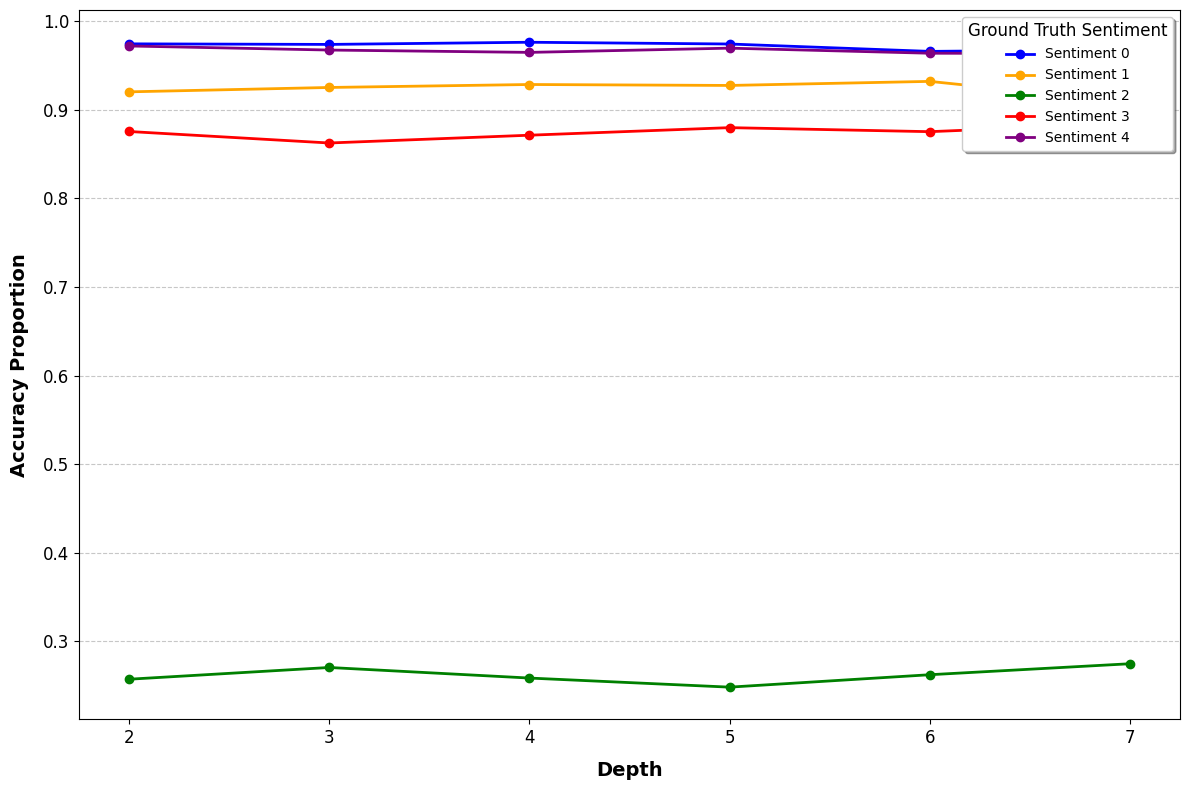

In [ ]:
# Create the plot
plt.figure(figsize=(12, 8))
colors = ['blue', 'orange', 'green', 'red', 'purple']  # Assign distinct colors for each sentiment class

for idx, sentiment in enumerate(accuracy_proportions_filtered_phrase.columns):
    plt.plot(
        accuracy_proportions_filtered_phrase.index,
        accuracy_proportions_filtered_phrase[sentiment],
        label=f"Sentiment {sentiment}",
        marker='o',
        linestyle='-',
        linewidth=2,
        color=colors[idx]
    )

# Customize axes and labels
plt.xlabel("Depth", fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel("Accuracy Proportion", fontsize=14, labelpad=10, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(
    title="Ground Truth Sentiment",
    title_fontsize=12,
    fontsize=10,
    loc='upper right',
    frameon=True,
    shadow=True
)


# Adjust layout for better visual appeal
plt.tight_layout()

# Display the plot
plt.show()


## Error proportions per depth for sentiment

In [ ]:
# Group by depth and ground_truth to calculate error proportions
error_proportions = errors_df.groupby(['depth', 'ground_truth']).size().unstack(fill_value=0)

# Normalize each sentiment by the total nodes at each depth
error_proportions = error_proportions.div(errors_df.groupby('depth')['total_nodes'].first(), axis=0)

In [ ]:
# Calculate accuracy as 1 - error_proportion
accuracy_proportions = 1 - error_proportions

In [ ]:
# Filter accuracy_proportions to include only depths 2 to 7
accuracy_proportions_filtered = accuracy_proportions.loc[2:7]

## FINAL GRAPHS

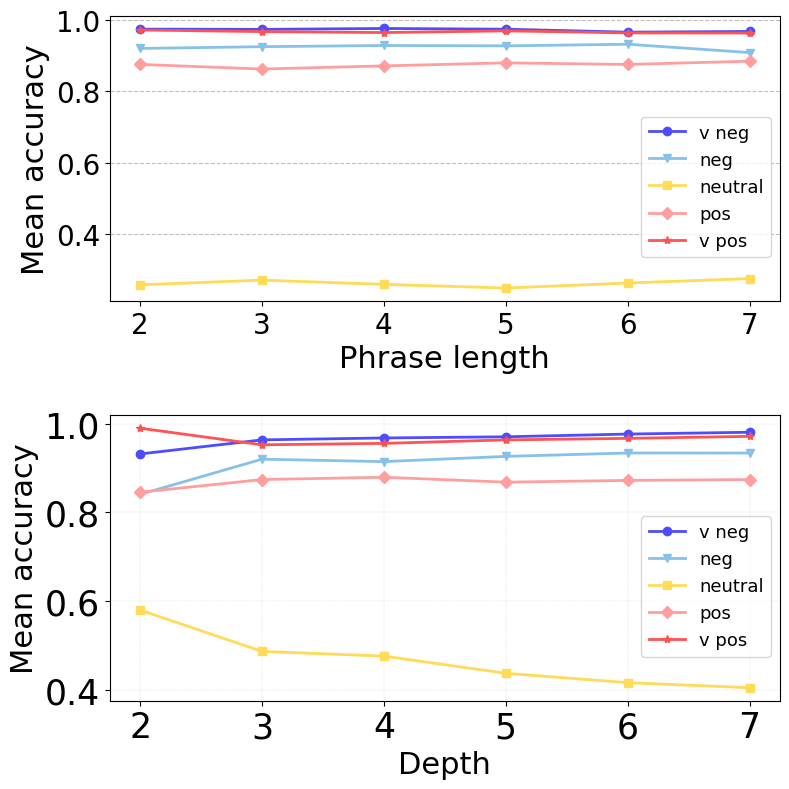

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

colors =["#4d4dff", "#85c1e9", "#FFDB58", "#ff9e9e", "#ff5252"]
markers = ['o', 'v', 's', 'D', '*']

# First subplot
for idx, sentiment in enumerate(accuracy_proportions_filtered_phrase.columns):
    axes[0].plot(
        accuracy_proportions_filtered_phrase.index,
        accuracy_proportions_filtered_phrase[sentiment],
        label=f"Sentiment {sentiment}",
        marker=markers[idx],
        linestyle='-',
        linewidth=2,
        color=colors[idx]
    )

axes[0].set_xlabel("Phrase length", fontsize=22)
axes[0].set_ylabel("Mean accuracy", fontsize=22)
axes[0].grid(axis='y', linestyle='--', alpha=0.8)
axes[0].tick_params(axis='both', labelsize=20)

# Second subplot
for idx, sentiment in enumerate(accuracy_proportions_filtered.columns):
    axes[1].plot(
        accuracy_proportions_filtered.index,
        accuracy_proportions_filtered[sentiment],
        label=f"Sentiment {sentiment}",
        marker=markers[idx],
        linestyle='-',
        linewidth=2,
        color=colors[idx]
    )

axes[1].set_xlabel("Depth", fontsize=22)
axes[1].set_ylabel("Mean accuracy", fontsize=22)
axes[1].grid(axis='y', linestyle='--', alpha=0.8, linewidth=2)
axes[1].tick_params(axis='both', labelsize=25)

custom_labels = ["v neg", "neg", "neutral", "pos", "v pos"]

# Add legends to each subplot, slightly moved down
axes[0].legend(
    labels = custom_labels,
    loc='center right',
    fontsize=13,
    title_fontsize=14,
    bbox_to_anchor=(1, 0.4)
)

axes[1].legend(
    labels = custom_labels,
    loc='center right',
    fontsize=13,
    title_fontsize=13,
    bbox_to_anchor=(1, 0.4)
)

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.2, alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()


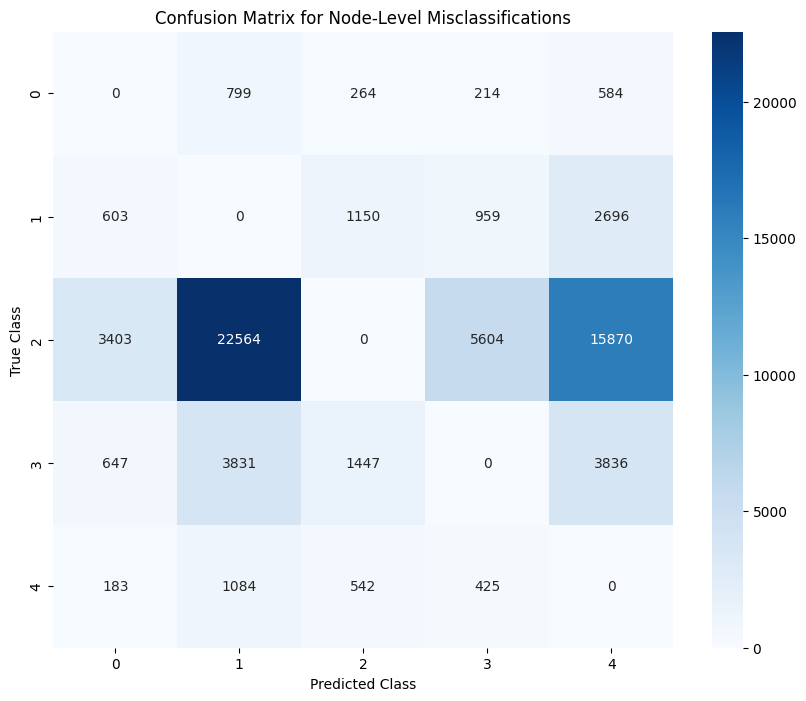

In [ ]:
import numpy as np
import seaborn as sns

num_classes = 5  # Assuming 5 sentiment classes (0 to 4)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

for error in errors:
    if error['type'] == 'node':
        confusion_matrix[error['ground_truth'], error['prediction']] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix for Node-Level Misclassifications")
plt.show()
